## Repurposing peptide inhibitors for SARS-Cov-2 spike protein using models trained on topological features
<b>Somesh Mohapatra</b><sup>a</sup><br>
<sup>a</sup>Massachusetts Institute of Technology, Cambridge, MA 02139. USA.<br>
someshm [at] mit.edu

## 1. Introduction

Protein-protein interactions (PPIs) form the molecular basis of processes that equally sustain life and drive development of disease, such as SARS-Cov-2. PPIs are critical for regulating signal transduction, metabolic pathways, and cell cycles. ([Petta, et al., 2016](https://www.sciencedirect.com/science/article/pii/S1525001616309947?via%3Dihub)) Therefore, disruption of these PPIs represents an attractive therapeutic modality. Peptides have garnered therapeutic interest due to their potential to disrupt clinically-relevant PPIs. ([Tsomaia, et al., 2015](http://europepmc.org/article/med/25591543)) Their synthetic accessibility, amenability to chemical tailoring, and potential for cell penetration have made them increasingly popular starting points in drug discovery. ([Mohapatra, et al., 2020](https://pubs.acs.org/doi/10.1021/acscentsci.0c00979), [Schissel, et al., 2020](https://www.biorxiv.org/content/10.1101/2020.04.10.036566v1)) However, the exponential scaling of the possible peptide sequences (<i>N</i><sup><i>n</i></sup>, where <i>N</i> is number of possible amino acids and <i>n</i> is sequence length), and routine identification of non-specific binders in high throughput experimental screening act as an impediment to the design of effective binders.

Machine learning has accelerated efforts in virtual screening. ([Stokes, et al., 2020](https://www.sciencedirect.com/science/article/pii/S0092867420301021), [Yoshida, et al., 2018](https://www.sciencedirect.com/science/article/pii/S2451929418300275)) For peptides specifically, there are multiple instances where machine learning models trained over data from generated libraries or public databases have predicted peptides that experimentally demonstrate higher activity. ([Schissel, et al., 2020](https://www.biorxiv.org/content/10.1101/2020.04.10.036566v1), [Basith, et al., 2020](https://onlinelibrary.wiley.com/doi/abs/10.1002/med.21658)) Accurate predictions of PPIs have been demonstrated using three-dimensional structures of target protein and peptides. ([Cunningham, et al., 2020](https://www.nature.com/articles/s41592-019-0687-1)). However, these approaches are limited because they require significant computational resources to train deep 3D convolutional neural network models. The recent use of geometric deep learning has provided a conceptual framework that advances the field significantly. ([Gainza, et al., 2020](https://www.nature.com/articles/s41592-019-0666-6))

In this notebook, we developed an approach combining conventional physicochemical parameter analysis and topological featurization to train robust one-class classifiers to predict PPIs. We used the top-performing model to screen the peptides in the current dataset against SARS-Cov-2 receptor binding domain protein. We used the Peptide Binding DataBase (PepBDB) for model training. ([Wen, et al., 2019](https://academic.oup.com/bioinformatics/article/35/1/175/5050021))

## 2. Methodology

In this section, we have elaborated on our approach/reasoning in the specific parts of the code. We also explain the utility of 2 custom python scripts - `featurize_pdb.py` and `utils_occ_model.py` - whose code has been separated to make room for a cleaner notebook.

### Installation and importing of packages

In [ ]:
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
!conda update conda -y -q
!source /usr/local/etc/profile.d/conda.sh
!conda init 
!conda install -n root _license -y -q
!conda create -c conda-forge -n ppi_tda rdkit python=3.8

!conda activate ppi_tda
!pip install frozendict
!pip install scikit-learn==0.23.2
!pip install giotto-tda
!pip install biopython
!conda install -c conda-forge mdtraj

In [18]:
import os
import sys

import warnings
warnings.filterwarnings('ignore')

In [25]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, NumberOfPoints, Amplitude
from gtda.plotting import plot_diagram, plot_point_cloud

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Custom libraries - Development and import

This notebook is accompanied by 2 python scripts, `featurize_pdb.py` and `utils_occ_model.py`. Both of these scripts have been developed taking into account the custom requirements for handling protein/peptide data files. The data files follow the Protein Data Bank (PDB) convention, in which the residues in the protein, corresponding atoms, and their positions in the Cartesian coordinate space, are noted.

`featurize_pdb.py` loads the PDB files into 3 different formats, `text`, `<RDKit_mol>` and `<MDTraj_traj>`, as per the user's request of `feature_type`. 

If the `feature_type` is `Coulomb`, then the file is loaded as an `<RDKit_mol>` object. The `mol` object is used to generate an atom-atom pairwise charge interaction matrix, called the Coulomb matrix. This matrix shows how the charge distribution is in the protein/peptide. The computation of the Coulomb matrix is costly, hence, only peptides are featurized using this method.

If the `feature_type` has the sub-string `PC`, then the file is loaded as an `<MDTraj_traj>` object. The `traj` object is used to generate an array of 3D coordinates, corresponding to the Cartesian coordinates of the atoms. If the user does not specify `Mass` as a part of the `PC` `feature_type`, then the function returns the coordinates alone. In the case where `Mass` is specified, there is a further round of computation where the atomic mass (in a.u.) of each element corresponding to the Cartesian coordinates is noted from a stored dictionary `elements_dict`, and appended to the coordinates vector. In both cases, the protein/peptide is featurized as an array, <i>(n_atoms, n_features)</i>, where <i>n_features</i> is 3 for the coordinates, and 4 if `Mass` is specified.

When the `feature_type` is noted as `Parameters`, the PDB file is parsed line-by-line to extract the protein sequence as 1-letter residue codes from the 3-letter codes, using a stored dictionary `letters`. The protein sequence is parsed through `biopython` to generate a `ProteinAnalysis` object. This object computes the several physicochemical parameters, such as secondary structure, hydropathy, isolectronic point, amongst others, which are used to featurize the protein sequence. This code only supports PDBs with natural residues. Given the significantly low computational costs to featurize protein/peptide PDB files as `Parameters`, we have featurized the larger `protein receptor` PDBs across all tasks using `Parameters`. In addition to that, we have benchmarked models using this representation for peptides.


`utils_occ_model.py` supports the model development, by pre-processing the data, creating train-validation-test splits, and training of the one-class classifiers. Unfortunately, `scikit-learn` does not provide for a way to optimize one-class classifiers. The use of `GridSearchCV` in `scikit-learn` and `BayesSearchCV` in `scikit-optimize` is plagued with errors, from failing to load the [model instance](https://github.com/NicolasHug/Surprise/issues/212) to [integer transform issues](https://github.com/scikit-optimize/scikit-optimize/issues/877). 

In absence of support from `scikit-learn`, the `utils_occ_model.py` script provides for pre-processing of features using `occ_feature_preprocess`, by concatenating different data and addressing the case where a `y` label is not available, as the dataset at hand has only positive labels. Further, `occ_training` finds the best model using grid search for 2 different types of one-class classifiers - [Support Vector Machine](http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) and [Isolation Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

In [28]:
import featurize_pdb
import utils_occ_model

### Define paths for the dataset and custom values for filtering
For this repository, the data was downloaded from [PepBDB](http://huanglab.phys.hust.edu.cn/pepbdb/db/download/) (accessed on April 30, 2021). The accompanying `peptide_list.txt` file was cleaned, column headers were added, and made available as `peptide_list.csv` in the `Dataset` folder. For the purpose of this notebook and given time constraints, a portion of the PepBDB dataset, containing 100 receptor-peptide combinations, was selected at random and made available in `Dataset/pepbdb`. The code has been run against the complete dataset.

<b>Variables to define the path:</b><br>
`PATH`: home folder of the files - dataset, peptide_list<br>
`PATH_PEPTIDE_LIST`: location of the peptide_list<br>
`PATH_DATA`: location of the folder containing the PDB files<br>

<b>Variables to filter the dataset:</b><br>
`MIN_RES`: float, mimimum resolution of the protein-peptide complex in the PDB file<br>
`MAX_RES`: float, maximum resolution of the protein-peptide complex in the PDB file<br>
`NON_CANONICAL_PEPTIDE`: list, `peptide_list` notes the peptides with non-canonical residues as 1<br>
In this ntoebook, only peptides with natural residues have been analyzed, hence the default value is `[0]`. If all peptides need to be included, then this can be changed to `[0, 1]`, or if only peptides with non-canonical residues need to be analyzed, this can be changed to `[1]`.<br>

<b>Other Variables:</b><br>
`SAMPLE`: int/float, selection of a particular number/fraction of the sequences<br>
`SEED`: int, seed for pseudo-random generator for sampling and training purposes

In [3]:
PATH = './'
PATH_PEPTIDE_LIST = os.path.join(PATH, 'Dataset', 'peptide_list.csv')
PATH_DATA = os.path.join(PATH, 'Dataset', 'pepbdb')

In [4]:
NON_CANONICAL_PEPTIDE = [0]
MIN_RES= 0
MAX_RES= 5

SEED=108
SAMPLE = 100

### Sequence dataset Loading and filtering
The dataset of PDB files is summarized in `peptide_list.csv`, with information of `PDB_ID`, `peptide_chain_ID`, `noncanonical_peptide`, and `resolution`, amongst others. This list is used to filter the PDB files for further usage.

In this notebook, the abridged dataset is used for demonstration.

The distribution of the lengths of peptide is shown. Length is one of the bottle-necks in computation and processing of the features.

In [5]:
df_peptide_list = pd.read_csv(PATH_PEPTIDE_LIST)

df_peptide_list = df_peptide_list[
    df_peptide_list['noncanonical_peptide'].isin(NON_CANONICAL_PEPTIDE)]

In [6]:
df_peptide_list = df_peptide_list.sample(
    SAMPLE, random_state=SEED).reset_index(drop=True)

(array([15., 20., 12.,  7., 10.,  8., 14.,  6.,  5.,  3.]),
 array([ 2. ,  6.2, 10.4, 14.6, 18.8, 23. , 27.2, 31.4, 35.6, 39.8, 44. ]),
 <BarContainer object of 10 artists>)

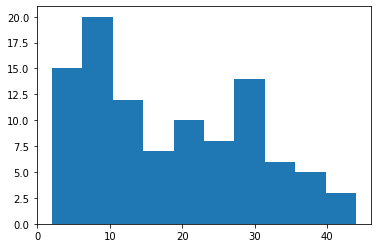

In [112]:
plt.hist(df_peptide_list['peptide_length'])

### Featurization of receptors and peptides
Receptor protein and peptide, in the PDB files, are featurized using `class Featurize_PDB` in the `featurize_pdb.py` script. An instance of this class is created and used for featurization of receptors and peptides.

By convention, `receptor` denotes the larger protein in the complex, and `peptide` denotes the smaller protein. In the file scheme of PepBDB, the same convention has been used. Each folder in `Dataset/pepbdb` has a folder by the name of the PDB ID followed by the peptide chain. For example, `1a1n_C`, where `1a1n` is the PDB ID and `C` is the chain ID. This information can also be looked up in the [PDB database](https://www.rcsb.org/).

Receptor proteins are large proteins, and featurized using physicochemical parameters obtained using `ProteinAnalysis` in `biopython`.

Peptides are relatively smaller proteins, hence computationally cheaper to featurize. They have been represented using Coulomb matrix, point cloud of Cartesian coordinates of heavy atoms (as noted in the PDB file) and point cloud of Cartesian coordinates of heavy atoms with a fourth value which represents the mass of the corresponding atom. The featurization types has been noted in a list `peptide_feature_types` and used through the notebook to define keys in the dictionary and train models. Physico-chemical parameters for peptides have also been computed to benchmark the models.

`try` and `except` is used to handle exceptions arising from processing of PDB files with improper entries. Features for both receptors and peptides which pass this exception-handling statement are stored in `receptor_features` list, `peptide_param_features` list (for benchmarking) and `peptide_raw_features` dictionary. `dictionary` data type has been used for `peptide_raw_features` to conveniently handle all the different features used for peptides.

In [33]:
peptide_feature_types = ['Coulomb', 'PC', 'PC-Mass']

In [69]:
featurize = featurize_pdb.Featurize_PDB()

Featurize PDB as Coulomb Matrix, Point Cloud, and Protein Parameters


In [9]:
%%capture
receptor_features = []
peptide_param_features = []

peptide_raw_features = {feature:[] for feature in peptide_feature_types}
for idx in range(df_peptide_list.shape[0]):
    pdb_chain_id = ''.join((
        df_peptide_list.iloc[idx]['PDB_ID'], '_', 
        df_peptide_list.iloc[idx]['peptide_chain_ID']))
    
    path_folder = os.path.join(PATH_DATA, pdb_chain_id)
    try:
        tmp_peptide_feature = {}
        for feature in peptide_raw_features:
            tmp_peptide_feature[feature] = featurize.featurize(path_folder, 'peptide.pdb', feature)

        tmp_receptor_feature = featurize.featurize(path_folder, 'receptor.pdb', 'Parameters')
        tmp_peptide_param_feature = featurize.featurize(path_folder, 'peptide.pdb', 'Parameters')

    except: 
        continue
    
    for feature in peptide_raw_features:
        peptide_raw_features[feature].append(tmp_peptide_feature[feature])
    receptor_features.append(tmp_receptor_feature)
    peptide_param_features.append(tmp_peptide_param_feature)

Owing to issues in the featurization process, arising from mishandling of PDB in `RDKit` and `MDTraj` objects, a post-featurization filtering using `utils_occ_model.filter_dataset` is used. This removes any `None` values in both `receptor_features` and `peptide_features` lists.

The filtered datasets are stored as dictionaries by `feature_type` for further usage.

`indices_list` returned from the function notes down the indices in the original `peptide_list` dataframe that have been carried forward for further analysis. This list has been used to obtain a filtered dataframe, `df_filter`.

In [95]:
dict_receptor_features, dict_peptide_features = {}, {}

for feature in peptide_raw_features:
    (dict_receptor_features[feature], 
     dict_peptide_features[feature], 
     indices_list) = utils_occ_model.filter_dataset(
        receptor_features, peptide_raw_features[feature])

In [100]:
df_filter = df_peptide_list.loc[indices_list].reset_index(drop=True)

### Featurization of peptides using <i>giotto-tda</i>
Peptide features - Coulomb matrices, point clouds with coordinates, and point clouds with coordinates and mass - have been featurized using topological representations obtained from <i>giotto-tda</i>.

Peristence diagrams for peptide features have been calculated using `VietorisRipsPersistence`, with `euclidean` metric for point clouds, and `precomputed` for Coulomb matrices. The homology dimensions have been set to `[0, 1, 2]` tracking connected components, loops, and voids.

For this section, we have referred to the tutorial on [Classifying 3D shapes](https://giotto-ai.github.io/gtda-docs/latest/notebooks/classifying_shapes.html) provided in the <i>[giotto-tda](https://giotto-ai.github.io/)</i> documentation (accessed on April 30, 2021).

In [11]:
persistence_diagrams = {}

for feature in peptide_feature_types:
    metric = 'precomputed' if feature is 'Coulomb' else 'euclidean'
    VR = VietorisRipsPersistence(metric=metric, homology_dimensions=[0, 1, 2], n_jobs=-1)
    persistence_diagrams[feature] = VR.fit_transform(dict_peptide_features[feature])

In [39]:
plot_diagram(persistence_diagrams['PC'][0])

Persistence diagrams have been used to compute persistence entropy, number of off-diagonal points per homology dimension, and a vector of amplitudes, using the pre-defined functions in `gtda.diagrams`.

In [12]:
persistence_entropy = {}

for feature in peptide_feature_types:
    PE = PersistenceEntropy()
    persistence_entropy[feature] = PE.fit_transform(persistence_diagrams[feature])

Point cloud of persistence entropy across the 3 homology dimensions shows the variation in the peptide features.

In [44]:
plot_point_cloud(persistence_entropy['PC-Mass'])

In [13]:
number_of_points = {}
for feature in peptide_feature_types:
    for diagram in persistence_diagrams[feature]:
        number_of_points[feature] = NumberOfPoints().fit_transform(
            persistence_diagrams[feature])

In [14]:
amplitude = {}
for feature in peptide_feature_types:
    for diagram in persistence_diagrams[feature]:
        amplitude[feature] = Amplitude(metric='wasserstein').fit_transform(
            persistence_diagrams[feature])

### Dataset preparation for model training
One-class classifiers are trained using `utils_occ_model.occ_training` on the pre-processed dataset. 

Physico-chemical parameters of receptor and topological features of peptides are concatenated to a feature vector, per protein-peptide sample using `utils_occ_model.occ_feature_preprocess`. `X_train` and `X_test` are stored as dictionaries with `feature_type` key values. In addition to the `peptide_feature_types`, physico-chemical parameters for both protein and peptide have been updated as `Parameters` `feature_type`.

The default split for training and testing, 80: 20, has been used in this notebook. This can be changed by passing a float value for the `test_split` in the `occ_feature_preprocess` function.

As a gentle reminder, no class labels as `y_train` and `y_test` are present here, since this is a one-class classification.

In [63]:
X_train, X_test = {}, {}

for feature in peptide_feature_types:
    X_train[feature], X_test[feature], _, _ = utils_occ_model.occ_feature_preprocess(
        X=[dict_receptor_features[feature], 
           persistence_entropy[feature], 
           number_of_points[feature],
           amplitude[feature]])
    
    X_train[feature+'_Params'], X_test[feature+'_Params'], _, _ = utils_occ_model.occ_feature_preprocess(
        X=[dict_receptor_features[feature], 
           peptide_param_features,
           persistence_entropy[feature], 
           number_of_points[feature],
           amplitude[feature]])
    
X_train['Parameters'], X_test['Parameters'], _, _ = utils_occ_model.occ_feature_preprocess(
        X=[receptor_features, peptide_param_features])

## 3. Benchmark - Results and Experiments

### Model training
To obtain the best feature type and model architecture, and benchmark others, we train 2 one-class classifiers, optimized over an exhaustive list of hyperparameters, over 7 feature types. For this purpose, we use `utils_occ_model.occ_training` which handles the splitting of the training data into train and validation sets, and trains a suite of models for different hyperparameter combinations. 

2 one-class classifiers in the `scikit-learn` package, [Support Vector Machine](http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) and [Isolation Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) have been implemented. Parameters and corresponding hyperparameters for each model architecture have been noted in a dictionary `model_params`. Apart from the default parameters, user-defined parameters are also handled using the `dict_params` argument in the `occ_training` function.

For the peptides, we have studied how the augmentation of physico-chemical parameters with topological feature representations can impact the model performance. In total, we obtain 3 feature sets same as the earlier `feature_type` defined in `peptide_feature_types`, along with 3 augmented feature sets and 1 benchmark feature set with the physico-chemical parameters alone.

The code splits the data into a final set of <b>60: 20: 20</b>, <b>training: validation: test</b>, with a pre-defined `val_split` argument. This argument can also be passed by the user, along with the `random_state` for the splitting.

`occ_training` function takes `X_train` and `model_type` as input, and returns `best_model`, `best_params`, `best_accuracy`. The best model is scored by the accuracy on the validation dataset during model training. It is noted that the parameters for the best model can be obtained by querying the `scikit-learn` model instance. However, for ease of access to the specific parameters for the user, this has been included as an additional attribute.

The output of a one-class classifier is either `1` or `-1`, where `1` denotes that the feature vector belongs to the classm and vice-versa. Accuracy is computed as a sum of the classifier outputs divided by the total number of samples, where if all output classes are `1`, then the accuracy is 1.0.

In [64]:
model_arch_types = ['svm', 'isoforest']

top_models = {feature:{} for feature in X_train}
top_params = {feature:{} for feature in X_train}
top_val_acc = {feature:{} for feature in X_train}

for feature_type in X_train:
    for model_type in model_arch_types:
        (top_models[feature_type][model_type], 
         top_params[feature_type][model_type], 
         top_val_acc[feature_type][model_type]) = utils_occ_model.occ_training(
            X_train[feature_type], model_type)

In [65]:
top_test_acc = {feature:{} for feature in X_train}

for feature_type in X_train:
    for model_type in model_arch_types:
        top_test_acc[feature_type][model_type] = utils_occ_model.occ_scorer(
            top_models[feature_type][model_type], X_test[feature_type])

In the following 2 dataframes, we have summarized the accuracy values for the validation and test datasets. The addition of topological features, in conjunction with the [Isolation Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) one-class classifier is noted to be a top performing combination. 

Given the limited data that we have trained on, the performance of using just the physico-chemical parameters is shown to be unusally high. This result might be caused due to a lot similar proteins in the sampled dataset. In other experiments (not in this notebook) with the complete dataset, we observed that the Isolation Forest models trained with topological features performs better than the physico-chemical parameters. We also observed that augmented feature set performs slightly better than using topological features alone.

To remain consistent to the representations and the dataset in this notebook, we have used the `PC-Mass-isoforest` `feature-model_type` combination in further analysis.

In [66]:
pd.DataFrame.from_dict(top_val_acc)

,Coulomb,Coulomb_Params,PC,PC_Params,PC-Mass,PC-Mass_Params,Parameters
svm,0.421053,0.421053,0.473684,0.473684,0.473684,0.473684,0.473684
isoforest,0.789474,0.842105,0.789474,0.789474,0.894737,0.789474,0.842105


In [67]:
pd.DataFrame.from_dict(top_test_acc)

,Coulomb,Coulomb_Params,PC,PC_Params,PC-Mass,PC-Mass_Params,Parameters
svm,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947
isoforest,0.684211,0.789474,0.736842,0.789474,0.736842,0.736842,0.894737


### Repurposition for SARS-Cov-2 RBD protein
We used the `PC-Mass-isoforest` model to screen the peptides in the dataset with the features of the SARS-Cov-2 receptor binding domain (RBD) protein. We downloaded a pre-processed PDB file for RBD protein (PDB ID: [6XM0](https://www.rcsb.org/structure/6XM0)) from [PDB database](https://www.rcsb.org/). (accessed on April 30, 2021) This file had only one chain of the RDB protein and did not include any non-canonical amino acids or glycans.

The PDB file was featurized using `featurize_pdb` with `Parameters` `feature_type`, and stored in `rbd_features`. The list of receptor features was concatenated with the peptide features into `X_rbd_peptide`.

The indices for the positive predictions, `1` from the top model, which indicated the peptides that bound to the RBD protein (noted in `rbd_pred`). These indices were matched with the corresponding PDB IDs in `df_filter`.

In [ ]:
top_feature_type = 'PC-Mass'
top_model_type = 'isoforest'

In [81]:
rbd_features = featurize.featurize(
    path_folder = os.path.join(PATH, 'Dataset'), 
    file_name = 'sars_cov2_rbd.pdb',
    feature_type = 'Parameters')

In [87]:
X_rbd_peptide = np.hstack([
    len(persistence_entropy[top_feature_type])*[rbd_features], 
    persistence_entropy[top_feature_type], 
    number_of_points[top_feature_type],
    amplitude[top_feature_type]])

In [101]:
rbd_pred = top_models['PC-Mass']['isoforest'].predict(X_rbd_PC_Mass)

In [110]:
df_filter.loc[[idx for idx, pred in enumerate(rbd_pred) if pred == 1]][
    ['PDB_ID', 'peptide_chain_ID']].head()

,PDB_ID,peptide_chain_ID
0,4nuf,P
2,1kpv,P
3,2c3i,A
4,5xym,a
6,1k6f,A


To understand if the results are likely, we checked the top 3 PDB IDs shown here, and tried to correlate it with known understanding of general biology and of the SARS-Cov-2 system. The analysis has been done, by each PDB ID - <br>
[4NUF](https://www.rcsb.org/structure/4NUF): Peptide bound to Escherechia coli, a known microbe which affects humans.<br>
[1KPV](https://www.rcsb.org/structure/1KPV): Peptide bound to MHC class I complex, which will incite immunogenic response. This might be a false positive.<br>
[2C3I](https://www.rcsb.org/structure/2C3I): Peptide bound to PIM 1 kinase, kknwon to responsible for cardiovascular malignancies. Recent studies have noted SARS-Cov-2 as a vascular disease, so this might be a good binder. ([Siddiqui, et al., 2021](https://linkinghub.elsevier.com/retrieve/pii/S1050173820301286), [Lei, et al., 2021](https://www.ahajournals.org/doi/10.1161/CIRCRESAHA.121.318902)) <br>

These preliminary results indicate that more analysis into both methodology and selection can aid in finding peptide-based inhibitors for PPI, not only for SARS-Cov-2 but also for other diseases where the protein is known.

## 4. Limitations and perspectives
We note that there are certain limitations to this approach, and provide suggestions on how they may be overcome -<br>
- Need for 3D data for peptides and proteins: Despite the significantly large size of [PepBDB](https://academic.oup.com/bioinformatics/article/35/1/175/5050021) dataset with 13,000+ entries, it still falls short of the protein sequences in millions noted in [UniProt](https://www.uniprot.org/). We suggest that for known proteins, molecular dynamics simulation approaches can be used to obtain 3D structures for peptides and they can be screened against. Similarly, individual structures for the receptor protein can be used in the absence of receptor-peptide complexes to augment the dataset.
- Understanding of topological features and manifolds: Proteins and peptides are being only recently studied using topological featurization methods. Even then, featurization in non-Euclidean manifolds for proteins remains an esoteric area of research. Deeper studies in understanding the different representations and their effects on model performance can significantly impact the field.
- Experimental validation of predictions: Given the difficult task to synthesize and validate in wet lab experiments, understanding of the efficacy of the models remains an open challenge.

In summary, we demonstrated the power of topological representations to learn PPIs. In this notebook, we showed how public PPI datasets with 3D information of peptide and protein can be used to develop robust models, and used for different applications, such as repurposition of peptide inhibitors. In addition to that, we repurposed peptide inhibitors, and correlated the predictions for 3 bound peptides with contemporary knowledge.